In [18]:
from django.core.management import setup_environ
import settings
# from django.conf import settings
setup_environ(settings)

'/home/wahern/projects/millstone/genome_designer'

In [3]:
# import os
# import tempfile

# from Bio import SeqIO
# from django.conf import settings
# import pysam

# from genome_finish.millstone_de_novo_fns import get_insertion_location
# from genome_finish.millstone_de_novo_fns import get_local_contig_placement
# from genome_finish.millstone_de_novo_fns import make_sliced_fasta
# from main.exceptions import ValidationException
# from main.model_utils import get_dataset_with_type
# from main.models import Dataset
# from main.models import AlignmentGroup
# from main.models import Chromosome
# from main.models import ExperimentSample
# from main.models import ExperimentSampleToAlignment
# from main.models import Variant
# from main.models import VariantAlternate
# from main.models import VariantSet
# from main.models import VariantToVariantSet
# from pipeline.read_alignment import align_with_bwa_mem
# from utils import convert_seqrecord_to_fastq
# from utils import generate_safe_filename_prefix_from_label
# from utils.import_util import add_dataset_to_entity
# from utils.import_util import copy_and_add_dataset_source
# from utils.reference_genome_maker_util import generate_new_reference_genome


from collections import defaultdict
import os
import re
import subprocess

from Bio import SeqIO
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from django.conf import settings
import pysam

from main.exceptions import ValidationException
from main.model_utils import get_dataset_with_type
from main.models import Chromosome
from main.models import Contig
from main.models import Dataset
from main.models import ExperimentSampleToAlignment
from main.models import Variant
from main.models import VariantAlternate
from main.models import VariantSet
from main.models import VariantToVariantSet
from utils.reference_genome_maker_util import generate_new_reference_genome

ENDPOINT_MODE_DIFFERENCE_CUTOFF = 2


def place_contig(contig, new_reference_genome_label):
    # Find the insertion position in reference and the end positions of the
    # insertion cassette in the contig
    insertion_placement_positions = get_insertion_placement_positions(contig)

    # Propogate error message upwards
    if 'error_string' in insertion_placement_positions:
        return insertion_placement_positions

    new_reference_genome_params = {
        'label': new_reference_genome_label
    }

    # Generate a new version of the reference genome with the
    # cassette incorporated
    is_reverse = contig.metadata.get('is_reverse', False)
    return place_cassette(
            contig,
            insertion_placement_positions,
            new_reference_genome_params,
            is_reverse)


def place_cassette(contig, insertion_placement_positions,
                   new_reference_genome_params, is_reverse=None):

    # Validate param dictionaries
    try:
        for key in ['reference', 'contig']:
            assert key in insertion_placement_positions
            for inner_key in ['left', 'right']:
                assert inner_key in insertion_placement_positions[key]
        assert 'label' in new_reference_genome_params
    except Exception as e:
        raise ValidationException(e)

    reference_genome = contig.parent_reference_genome
    # Get chromosome of reference genome to be recieving cassette
    # insertion_chromosome = Chromosome.objects.get(
    #     reference_genome=reference_genome,
    #     seqrecord_id=placement_position_params['ref_chromosome_seqrecord_id'])
    # TODO: UNHACK
    insertion_chromosome = Chromosome.objects.get(
            reference_genome=reference_genome)

    if insertion_placement_positions['reference']['left'] == insertion_placement_positions['reference']['right']:
        # Create variant to house insertion
        insertion_variant = Variant.objects.create(
                reference_genome=reference_genome,
                chromosome=insertion_chromosome,
                type=Variant.TYPE.INSERTION,
                position=insertion_placement_positions['reference']['left'] + 1,
                ref_value='')
    else:
        raise Exception('TODO: HANDLE INSERTION WITH DELETION')

    # Get Seqrecord
    contig_fasta = get_dataset_with_type(
            contig,
            Dataset.TYPE.REFERENCE_GENOME_FASTA).get_absolute_location()
    with open(contig_fasta) as fh:
            contig_seqrecord = SeqIO.parse(fh, 'fasta').next()

    # Determine whether contig is reverse complement relative to reference
    if is_reverse is None:
        is_reverse = contig.metadata.get('is_reverse', False)

    # Extract cassette sequence from contig
    if is_reverse:
        cassette_sequence = str(contig_seqrecord.seq.reverse_complement()[
            insertion_placement_positions['contig']['left']:
            insertion_placement_positions['contig']['right']])
    else:
        cassette_sequence = str(contig_seqrecord.seq[
                insertion_placement_positions['contig']['left']:
                insertion_placement_positions['contig']['right']])

    # Create the variant alternate for the cassette sequence
    insertion_variant.variantalternate_set.add(
            VariantAlternate.objects.create(
                    variant=insertion_variant,
                    alt_value=cassette_sequence))

    # House insertion variant in variant set to be applied to the ref
    insertion_variant_set = VariantSet.objects.create(
            reference_genome=reference_genome,
            label='insertion_variant_set')

    VariantToVariantSet.objects.create(
            variant=insertion_variant,
            variant_set=insertion_variant_set)

    return generate_new_reference_genome(
            insertion_variant_set,
            new_reference_genome_params)


def get_insertion_placement_positions(contig):

    read_unpacking_dir = contig.get_model_data_dir()
    if not os.path.exists(read_unpacking_dir):
        os.mkdir(read_unpacking_dir)

    contig_reads = extract_contig_reads(contig, read_unpacking_dir, 'clipped')

#     contig_reads = extract_adjacent_clipped_reads(contig, read_unpacking_dir, 'clipped')
    if len(contig_reads) == 0:
        return {'error_string':
                'No clipped reads were assembled into the contig'}

    extracted_clipped_read_dicts = extract_left_and_right_clipped_read_dicts(
            contig_reads)
    left_clipped = extracted_clipped_read_dicts['left_clipped']
    right_clipped = extracted_clipped_read_dicts['right_clipped']

    ref_insertion_endpoints = find_ref_insertion_endpoints(
            left_clipped, right_clipped)

    # Handle case of no endpoints found
    if (ref_insertion_endpoints['left'] is None and
            ref_insertion_endpoints['right'] is None):
        return {'error_string': ('Could not find left or right reference ' +
                'insertion endpoints using ' + str(len(contig_reads)) +
                ' clipped reads')}
    elif ref_insertion_endpoints['left'] is None:
        return {'error_string': ('Could not find left reference ' +
                'insertion endpoint using ' + str(len(contig_reads)) +
                ' clipped reads')}
    elif ref_insertion_endpoints['right'] is None:
        return {'error_string': ('Could not find right reference ' +
                'insertion endpoint using ' + str(len(contig_reads)) +
                ' clipped reads')}

    left_clipped_same_end = left_clipped[ref_insertion_endpoints['right']]
    right_clipped_same_end = right_clipped[ref_insertion_endpoints['left']]

    contig_insertion_endpoints = find_contig_insertion_endpoints(
            contig, read_unpacking_dir, left_clipped_same_end,
            right_clipped_same_end)

    # Propogate error upwards
    if 'error_string' in contig_insertion_endpoints:
        return contig_insertion_endpoints

    return {
            'reference': ref_insertion_endpoints,
            'contig': contig_insertion_endpoints
    }


# def old_get_insertion_placement_positions(contig):

#     read_unpacking_dir = contig.get_model_data_dir()
#     if not os.path.exists(read_unpacking_dir):
#         os.mkdir(read_unpacking_dir)

#     contig_reads = extract_contig_reads(contig, read_unpacking_dir, 'clipped')
#     if len(contig_reads) == 0:
#         return {'error_string':
#                 'No clipped reads were assembled into the contig'}

#     extracted_clipped_read_dicts = extract_left_and_right_clipped_read_dicts(
#             contig_reads)
#     left_clipped = extracted_clipped_read_dicts['left_clipped']
#     right_clipped = extracted_clipped_read_dicts['right_clipped']

#     ref_insertion_endpoints = find_ref_insertion_endpoints(
#             left_clipped, right_clipped)

#     # Handle case of no endpoints found
#     if (ref_insertion_endpoints['left'] is None and
#             ref_insertion_endpoints['right'] is None):
#         return {'error_string': ('Could not find left or right reference ' +
#                 'insertion endpoints using ' + str(len(contig_reads)) +
#                 ' clipped reads')}
#     elif ref_insertion_endpoints['left'] is None:
#         return {'error_string': ('Could not find left reference ' +
#                 'insertion endpoint using ' + str(len(contig_reads)) +
#                 ' clipped reads')}
#     elif ref_insertion_endpoints['right'] is None:
#         return {'error_string': ('Could not find right reference ' +
#                 'insertion endpoint using ' + str(len(contig_reads)) +
#                 ' clipped reads')}

#     left_clipped_same_end = left_clipped[ref_insertion_endpoints['right']]
#     right_clipped_same_end = right_clipped[ref_insertion_endpoints['left']]

#     contig_insertion_endpoints = find_contig_insertion_endpoints(
#             contig, read_unpacking_dir, left_clipped_same_end,
#             right_clipped_same_end)

#     # Propogate error upwards
#     if 'error_string' in contig_insertion_endpoints:
#         return contig_insertion_endpoints

#     return {
#             'reference': ref_insertion_endpoints,
#             'contig': contig_insertion_endpoints
#     }


def extract_contig_reads(contig, read_unpacking_dir, read_category='all'):

    READ_CATEGORY_TO_FILENAME = {
        'all': 'bwa_align.SV_indicants_with_pairs.bam',
        'without_mates': 'bwa_align.SV_indicants_no_dups.bam',
        'clipped': 'bwa_align.clipped.bam',
        'split': 'bwa_align.split.bam',
        'unmapped': 'bwa_align.unmapped.bam'
    }
    assert read_category in READ_CATEGORY_TO_FILENAME

    extract_contig_reads_executable = os.path.join(
            settings.TOOLS_DIR,
            'velvet/contrib/extractContigReads/extractContigReads.pl')

    assembly_dir = contig.metadata['assembly_dir']

    contig_node_number = contig.metadata['node_number']
    cmd = [extract_contig_reads_executable, str(contig_node_number),
           assembly_dir]
    cmd = ' '.join(cmd)

    contig_reads_fasta = os.path.join(
            contig.get_model_data_dir(),
            'extracted_reads.fa')
#     if not os.path.exists(contig_reads_fasta):
    with open(contig_reads_fasta, 'w') as fh:
        subprocess.call(cmd, shell=True, stdout=fh)

    p1 = re.compile('>(\S+)/(\d)')
    contig_reads = defaultdict(list)
    with open(contig_reads_fasta) as fh:
        for line in fh:
            m1 = p1.match(line)
            if m1:
                read_id = m1.group(1)
                read_number = int(m1.group(2))
                contig_reads[read_id].append(read_number)

    sv_indicant_reads_path = os.path.join(
            contig.metadata['assembly_dir'],
            '..',
            READ_CATEGORY_TO_FILENAME[read_category])

    sam_file = pysam.AlignmentFile(sv_indicant_reads_path)
    sv_indicant_reads_in_contig = []
    for read in sam_file:
        if read.is_read1:
            read_number = 1
        elif read.is_read2:
            read_number = 2
        else:
            raise Exception('Read is neither read1 nor read2')

        contig_read_numbers = contig_reads.get(read.query_name, [])
        if read_number in contig_read_numbers:
            sv_indicant_reads_in_contig.append(read)

    # # DEBUG:
    # from genome_finish.assembly import add_bam_track
    # extracted_reads_bam_file = os.path.join(
    #         contig.get_model_data_dir(), read_category + '.bam')
    # extracted_reads_alignment_file = pysam.AlignmentFile(
    #     extracted_reads_bam_file, "wb", template=sam_file)

    # for read in sv_indicant_reads_in_contig:
    #     extracted_reads_alignment_file.write(read)
    # extracted_reads_alignment_file.close()

    # label = ('Contig_' + str(contig.metadata['node_number']) + '_length_' +
    #         str(contig.num_bases) + '_' + str(read_category))
    # add_bam_track(
    #         contig.parent_reference_genome, extracted_reads_bam_file, label)

    return sv_indicant_reads_in_contig


def extract_left_and_right_clipped_read_dicts(sv_indicant_reads_in_contig):
    SOFT_CLIP = 4
    HARD_CLIP = 5
    CLIP = [SOFT_CLIP, HARD_CLIP]

    # Separate left and right clipped reads
    left_clipped = defaultdict(list)
    right_clipped = defaultdict(list)
    for read in sv_indicant_reads_in_contig:
        left_clipping = read.cigartuples[0][1] if read.cigartuples[0][0] in CLIP else 0
        right_clipping = read.cigartuples[-1][1] if read.cigartuples[-1][0] in CLIP else 0
        is_left_clipped = left_clipping > right_clipping
        is_right_clipped = right_clipping > left_clipping
        if is_left_clipped:
            left_clipped[read.reference_start].append(read)
        elif is_right_clipped:
            right_clipped[read.reference_end].append(read)

    return {
        'left_clipped': left_clipped,
        'right_clipped': right_clipped
    }


def find_ref_insertion_endpoints(left_clipped, right_clipped):
    """ left_clipped and right_clipped are dictionaries with lists of
    reads as values and the reference start and end of the clipped alignment
    as keys respectively
    """
    # Find positions in reference of most left clipping points
    left_clipped_list_sorted = sorted(
            left_clipped.items(), key=lambda x: len(x[1]), reverse=True)

    highest_clip_consensus = (len(left_clipped_list_sorted[0][1])
            if len(left_clipped_list_sorted) > 0 else 0)
    second_highest_clip_consensus = (len(left_clipped_list_sorted[1][1])
            if len(left_clipped_list_sorted) > 1 else 0)

    if (highest_clip_consensus - second_highest_clip_consensus
            > ENDPOINT_MODE_DIFFERENCE_CUTOFF):
        ref_ins_right_end = left_clipped_list_sorted[0][0]
    else:
        ref_ins_right_end = None


    # Same for right clipping
    right_clipped_list_sorted = sorted(
            right_clipped.items(), key=lambda x: len(x[1]), reverse=True)

    highest_clip_consensus = (len(right_clipped_list_sorted[0][1])
            if len(right_clipped_list_sorted) > 0 else 0)
    second_highest_clip_consensus = (len(right_clipped_list_sorted[1][1])
            if len(right_clipped_list_sorted) > 1 else 0)

    if (highest_clip_consensus - second_highest_clip_consensus
            > ENDPOINT_MODE_DIFFERENCE_CUTOFF):
        ref_ins_left_end = right_clipped_list_sorted[0][0]
    else:
        ref_ins_left_end = None

    return {
        'left': ref_ins_left_end,
        'right': ref_ins_right_end
    }


def write_read_query_alignments_to_fastq(reads, fastq_path):
    """Writes the aligned portion of each read into a fastq
    """

    query_alignment_seqrecords = []
    for read in reads:
        query_alignment_seqrecords.append(SeqRecord(
                Seq(read.query_alignment_sequence, IUPAC.ambiguous_dna),
                letter_annotations={'phred_quality':read.query_alignment_qualities},
                id=read.query_name,
                description=''))

    with open(fastq_path, 'w') as fastq_handle:
        SeqIO.write(query_alignment_seqrecords, fastq_handle, 'fastq')


def simple_align_with_bwa_mem(reads_fq, reference_fasta, output_bam_path):

    # Ensure reference fasta is indexed
    subprocess.call(' '.join([
            '%s/bwa/bwa' % settings.TOOLS_DIR,
            'index',
            reference_fasta
            ]),
            shell=True, executable=settings.BASH_PATH)

    # Align clipped query alignment fastq to contig
    align_input_args = ' '.join([
            '%s/bwa/bwa' % settings.TOOLS_DIR,
            'mem',
            '-t', '1', # threads
            reference_fasta,
            reads_fq])

    # To skip saving the SAM file to disk directly, pipe output directly to
    # make a BAM file.
    align_input_args += ' | ' + settings.SAMTOOLS_BINARY + ' view -bS -'

    # Run alignment
    with open(output_bam_path, 'w') as fh:
        subprocess.check_call(
                align_input_args, stdout=fh,
                shell=True, executable=settings.BASH_PATH)


def get_reads_with_mode_attribute(clipped_alignment_bam, get_attr_function,
                                  mode_difference_cutoff=ENDPOINT_MODE_DIFFERENCE_CUTOFF):
    alignment_ref_clip_positions = defaultdict(list)
    sam_file = pysam.AlignmentFile(clipped_alignment_bam)
    for read in sam_file:
        # Change to reference_start for left_clipped
        alignment_ref_clip_positions[get_attr_function(read)].append(read)
        # alignment_ref_end_positions[read.reference_end].append(read)

    alignment_ref_clip_positions_sorted = sorted(alignment_ref_clip_positions.items(), key=lambda x:len(x[1]), reverse=True)
    highest_consensus = len(alignment_ref_clip_positions_sorted[0][1])
    second_highest_consensus = len(alignment_ref_clip_positions_sorted[1][1]) if len(alignment_ref_clip_positions_sorted) > 1 else 0
    if highest_consensus - second_highest_consensus > mode_difference_cutoff:
        endpoint = alignment_ref_clip_positions_sorted[0][0]
    else:
        endpoint = None

    return endpoint


def find_contig_insertion_endpoints(contig, read_unpacking_dir, left_clipped_same_end, right_clipped_same_end):
    """ left_clipped_same_end/right_clipped_same_end are lists of
    left and right clipped reads all with the same left/right
    alignment endpoint, corresponding to the reference insertion
    right/left endpoint
    """
    # TODO: Handle case of same query_name reads being added to same fastq
    right_clipped_query_names = [read.query_name for read in right_clipped_same_end]
    assert len(right_clipped_query_names) == len(set(right_clipped_query_names))

    # Write left and right clipped query alignment sequences to fastq
    right_clipped_query_alignment_fq = os.path.join(
            read_unpacking_dir, 'right_clipped_query_alignment_seqs.fq')
    write_read_query_alignments_to_fastq(right_clipped_same_end,
                                         right_clipped_query_alignment_fq)
    left_clipped_query_alignment_fq = os.path.join(
            read_unpacking_dir, 'left_clipped_query_alignment_seqs.fq')
    write_read_query_alignments_to_fastq(left_clipped_same_end,
                                         left_clipped_query_alignment_fq)

    # Get BAM filenames for right_clipped and left_clipped alignments
    right_clipped_to_contig_bam = os.path.join(read_unpacking_dir,
            'right_clipped_to_contig.bwa_align.bam')
    left_clipped_to_contig_bam = os.path.join(read_unpacking_dir,
            'left_clipped_to_contig.bwa_align.bam')


    # Only perform alignment of right_clipped to contig
    contig_fasta = contig.dataset_set.get(
            type=Dataset.TYPE.REFERENCE_GENOME_FASTA).get_absolute_location()
    simple_align_with_bwa_mem(
            right_clipped_query_alignment_fq, contig_fasta,
            right_clipped_to_contig_bam)

    # Check if contig is reverse complement
    total_mapped_count = 0
    reversed_complementarity_count = 0
    sam_file = pysam.AlignmentFile(right_clipped_to_contig_bam)
    for read in sam_file:
        if not read.is_unmapped:
            total_mapped_count += 1
            if read.is_reverse:
                reversed_complementarity_count += 1

    if total_mapped_count == 0:
        return {'error_string':
                'Could not find sufficient homology to reference in contig'}
    REVERSED_COMPLEMENTARITY_FRACTION_CUTOFF = 0.75
    if reversed_complementarity_count / total_mapped_count > REVERSED_COMPLEMENTARITY_FRACTION_CUTOFF:
        contig.metadata['is_reverse'] = True
        contig.save()

    # Write reverse complement of contig to file if is reverse
    if contig.metadata.get('is_reverse', False):
        rc_contig_fasta = os.path.splitext(contig_fasta)[0] + '.reverse_complement.fa'
        contig_seqrecord = SeqIO.parse(contig_fasta, 'fasta').next()
        contig_seqrecord.seq = contig_seqrecord.seq.reverse_complement()
        SeqIO.write(contig_seqrecord, rc_contig_fasta, 'fasta')

        # Redo right_clipped alignment to reverse complement of contig
        simple_align_with_bwa_mem(
                right_clipped_query_alignment_fq, rc_contig_fasta,
                right_clipped_to_contig_bam)

        # Perform left_clipped alignmnet to reverse complement of contig
        simple_align_with_bwa_mem(
                left_clipped_query_alignment_fq, rc_contig_fasta,
                left_clipped_to_contig_bam)
    else:
        # Perform left_clipped alignmnet to contig
        simple_align_with_bwa_mem(
                left_clipped_query_alignment_fq, contig_fasta,
                left_clipped_to_contig_bam)

    # Find contig endpoints
    contig_ins_left_end = get_reads_with_mode_attribute(right_clipped_to_contig_bam, lambda r:r.reference_end)
    contig_ins_right_end = get_reads_with_mode_attribute(left_clipped_to_contig_bam, lambda r:r.reference_start)

    return {
        'left': contig_ins_left_end,
        'right': contig_ins_right_end
    }


In [8]:
from main.models import Contig

contig = Contig.objects.get(label='mg1655_lib1_rec07_NODE_25_length_3591_cov_144.856583')
get_insertion_placement_positions(contig)

{'error_string': 'Could not find sufficient homology to reference in contig'}

In [11]:
contig = Contig.objects.get(label='mg1655_lib1_rec07_NODE_25_length_3591_cov_144.856583')
read_unpacking_dir = contig.get_model_data_dir()
if not os.path.exists(read_unpacking_dir):
    os.mkdir(read_unpacking_dir)

contig_reads = extract_contig_reads(contig, read_unpacking_dir, 'all')
endpoints = []
for read in contig_reads:
    if not read.is_unmapped:
        endpoints.append(read.reference_start)
        endpoints.append(read.reference_end)



# if len(contig_reads) == 0:
#     return {'error_string':
#             'No clipped reads were assembled into the contig'}

# extracted_clipped_read_dicts = extract_left_and_right_clipped_read_dicts(
#         contig_reads)
# left_clipped = extracted_clipped_read_dicts['left_clipped']
# right_clipped = extracted_clipped_read_dicts['right_clipped']

# ref_insertion_endpoints = find_ref_insertion_endpoints(
#         left_clipped, right_clipped)

# # Handle case of no endpoints found
# if (ref_insertion_endpoints['left'] is None and
#         ref_insertion_endpoints['right'] is None):
#     return {'error_string': ('Could not find left or right reference ' +
#             'insertion endpoints using ' + str(len(contig_reads)) +
#             ' clipped reads')}
# elif ref_insertion_endpoints['left'] is None:
#     return {'error_string': ('Could not find left reference ' +
#             'insertion endpoint using ' + str(len(contig_reads)) +
#             ' clipped reads')}
# elif ref_insertion_endpoints['right'] is None:
#     return {'error_string': ('Could not find right reference ' +
#             'insertion endpoint using ' + str(len(contig_reads)) +
#             ' clipped reads')}

# left_clipped_same_end = left_clipped[ref_insertion_endpoints['right']]
# right_clipped_same_end = right_clipped[ref_insertion_endpoints['left']]

# contig_insertion_endpoints = find_contig_insertion_endpoints(
#         contig, read_unpacking_dir, left_clipped_same_end,
#         right_clipped_same_end)

# # Propogate error upwards
# if 'error_string' in contig_insertion_endpoints:
#     return contig_insertion_endpoints

# return {
#         'reference': ref_insertion_endpoints,
#         'contig': contig_insertion_endpoints
# }

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

(array([  4.,   4.,   2.,   2.,   2.,   8.,   4.,   2.,   6.,   2.,   2.,
          2.,   6.,   0.,   4.,   0.,   4.,   6.,   2.,   4.,   6.,   2.,
          2.,  78.,   2.,   0.,   0.,   0.,   8.,   6.,   2.,   4.,   4.,
         34.,   4.,   4.,   2.,   2.,   2.,   4.,   0.,   0.,   2.,   4.,
          4.,   0.,   4.,   0.,   4.,   2.,   4.,   0.,   0.,   0.,   2.,
         16.,   0.,   0.,   2.,   2.,  10.,   8.,   6.,   4.,   0.,   2.,
          6.,   0.,  10.,   2.,   2.,   6.,   4.,   2.,   2.,   0.,   8.,
          0.,   4.,   2.,   0.,   2.,   0.,   0.,   0.,   2.,   0.,   4.,
          0.,   8.,   0.,   6.,   4.,   0.,   4.,   4.,   0.,   6.,   4.,
          0.,   0.,   2.,   2.,   2.,   0.,   0.,   0.,   8.,   2.,   6.,
          2.,   4.,   4.,   4.,   7.,   1.,   4.,   2.,   2.,   8.,   0.,
          2.,   0.,   2.,   8.,   2.,   4.,   0.,   4.,   2.,   6.,   2.,
          2.,   6.,   0.,   0.,   2.,   0.,   4.,   2.,   6.,   2.,   0.,
          6.,   0.,   0.,   2.,   0., 

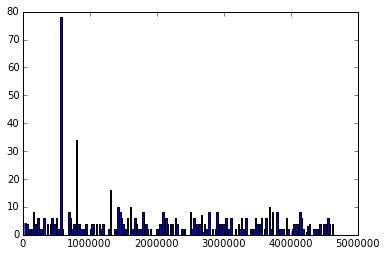

In [17]:
plt.hist(endpoints,200)

In [4]:
contig = Contig.objects.get(label='mg1655_lib1_rec07_NODE_25_length_3591_cov_144.856583')
read_unpacking_dir = os.path.join(contig.get_model_data_dir(), 'unmapped_pairs_testing')
unmapped_contig_reads = extract_contig_reads(contig, read_unpacking_dir, read_category='unmapped')

In [5]:
print len(unmapped_contig_reads), 'unmapped reads in contig'

original_align = contig.experiment_sample_to_alignment.dataset_set.get(type=Dataset.TYPE.BWA_ALIGN).get_absolute_location()
original_alignmentfile = pysam.AlignmentFile(original_align)

found_mates = []
for read in unmapped_contig_reads:
    if not read.mate_is_unmapped:
        mate = original_alignmentfile.mate(read)
        found_mates.append(mate)
print len(found_mates), 'mapped mates found'


18320 unmapped reads in contig
178 mapped mates found


In [40]:
unmapped_read = unmapped_contig_reads[0]
print 'unmapped_read:'
print '\tqname:', unmapped_read.qname
print '\tis_unmapped:', unmapped_read.is_unmapped
print '\tget_reference_positions:', unmapped_read.get_reference_positions()
print '\treference_start:', unmapped_read.reference_start
print '\treference_end:', unmapped_read.reference_end
unmapped_read_mate = origininal_alignmentfile.mate(unmapped_read)
print 'unmapped_read_mate.qname:', unmapped_read_mate.qname

unmapped_read:
	qname: HSQ700642:127:D0F9HACXX:5:1302:1693:7570
	is_unmapped: True
	get_reference_positions: []
	reference_start: 6133
	reference_end: None
unmapped_read_mate.qname: HSQ700642:127:D0F9HACXX:5:1302:1693:7570


In [56]:
found_mates = []
for read in unmapped_contig_reads:
    if not read.mate_is_unmapped:
        mate = original_alignmentfile.mate(read)
        found_mates.append(mate)
#     assert mate.is_unmapped == read.mate_is_unmapped

HSQ700642:127:D0F9HACXX:5:2308:20623:200484	77	-1	-1	0	None	-1	-1	100	TAGATCAGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAACGGAGCAGAGTGCTGCAGCTAGTGAG	array('B', [33, 28, 25, 33, 35, 35, 30, 35, 39, 37, 37, 37, 39, 38, 37, 39, 38, 39, 37, 39, 40, 39, 41, 41, 41, 36, 38, 40, 38, 39, 39, 33, 38, 33, 39, 41, 40, 40, 32, 26, 26, 36, 35, 38, 34, 36, 39, 39, 37, 37, 37, 27, 32, 36, 35, 31, 34, 34, 34, 34, 31, 34, 30, 25, 25, 29, 32, 30, 33, 33, 31, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])	[('AS', 0), ('XS', 0), ('RG', 'eab3affa')]


In [10]:
from genome_finish.assembly import add_bam_track
mates_of_unmapped_bam_file = os.path.join(
        contig.get_model_data_dir(), 'mates_of_unmapped.bam')

mates_of_unmapped_alignment_file = pysam.AlignmentFile(
    mates_of_unmapped_bam_file, "wb", template=original_alignmentfile)

for read in found_mates:
    mates_of_unmapped_alignment_file.write(read)

mates_of_unmapped_alignment_file.close()

label = ('Contig_' + str(contig.metadata['node_number']) + '_length_' +
        str(contig.num_bases) + '_mates_of_unmapped')

add_bam_track(contig.parent_reference_genome, mates_of_unmapped_bam_file, label)

In [9]:
mates_of_unmapped_bam_file

'/home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/6e766eb8/contigs/9f0f6e36/mates_of_unmapped.bam'

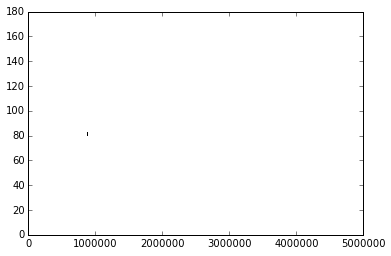

In [54]:
y=0
for read in found_mates:
    plt.hlines(y, read.reference_start, read.reference_end, lw=4)
    y+=1

In [17]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [22]:
import os

import pysam

from main.models import Contig
from main.models import Dataset
from genome_finish import insertion_placement_read_trkg
from genome_finish.assembly import add_bam_track

contig2_label = 'mg1655_lib1_rec07_NODE_22_length_5491_cov_157.923141'
contig = Contig.objects.get(label=contig2_label)

unmapped_contig_reads = insertion_placement_read_trkg.extract_contig_reads(contig, read_category='unmapped')
print len(unmapped_contig_reads), 'unmapped reads in contig'

original_align = contig.experiment_sample_to_alignment.dataset_set.get(type=Dataset.TYPE.BWA_ALIGN).get_absolute_location()
original_alignmentfile = pysam.AlignmentFile(original_align)
found_mates = []
for read in unmapped_contig_reads:
    if not read.mate_is_unmapped:
        mate = original_alignmentfile.mate(read)
        found_mates.append(mate)
print len(found_mates), 'mapped mates found'

mates_of_unmapped_bam_file = os.path.join(
        contig.get_model_data_dir(), 'mates_of_unmapped.bam')
mates_of_unmapped_alignment_file = pysam.AlignmentFile(
    mates_of_unmapped_bam_file, "wb", template=original_alignmentfile)
for read in found_mates:
    mates_of_unmapped_alignment_file.write(read)
mates_of_unmapped_alignment_file.close()

label = ('Contig_' + str(contig.metadata['node_number']) + '_length_' +
        str(contig.num_bases) + '_mates_of_unmapped')
add_bam_track(contig.parent_reference_genome, mates_of_unmapped_bam_file, label)



19179 unmapped reads in contig
357 mapped mates found


In [21]:
reload(insertion_placement_read_trkg)

<module 'genome_finish.insertion_placement_read_trkg' from 'genome_finish/insertion_placement_read_trkg.py'>

In [23]:
mates_of_unmapped_bam_file

'/home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/6e766eb8/contigs/a0c46b76/mates_of_unmapped.bam'

In [26]:
 samtools view /home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/6e766eb8/contigs/a0c46b76/mates_of_unmapped.bam

SyntaxError: invalid syntax (<ipython-input-26-e3d19c447ee6>, line 1)

In [28]:
contig.metadata['assembly_dir']

u'/home/wahern/projects/millstone/genome_designer/conf/../temp_data/projects/6e766eb8/alignment_groups/9c54183d/sample_alignments/ca0c79af/genome_finishing/2/velvet_k21'